# **Centralized training of a CNN on the MNIST-10 dataset**

### Installing dependencies

First of all, we install the necessary packages:

In [ ]:
# Multiple ways to import prflwr whether it is installed
# as a Python module, in a Colab environment or if source
# code is in a parent directory for local development.
def import_prflwr():
    import os
    try: import prflwr; return
    except: pass
    if "setup.py" in os.listdir("../.."):
        os.chdir("../..")
        try: import prflwr
        except: pass
        finally: os.chdir("experiments/fedls")
        if prflwr: return
    try:
        import google.colab
        os.system(
            "pip install git+https://github.com/passerim/peer-review-flower.git"
        )
        import prflwr; return
    except: raise ModuleNotFoundError("No module named 'prflwr'")


import_prflwr()

Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [ ]:
import os
import random
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.utils import make_grid

from prflwr.utils.dataset import non_iid_partitions

## Setup

Set useful constants, experiments settings and random seed.

In [ ]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [ ]:
# Setting random seed for reproducibility
SEED = 123
set_seed(SEED)

# Experimental settings
DATASET = "CIFAR10"  # possible values: "CIFAR10" or "CIFAR100"
NUM_EPOCHS = 30
BATCH_SIZE = 25
print(f"Training for {NUM_EPOCHS} epochs")

# Device to use for training and evaluation
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

Training for 30 epochs
Training on cuda:0


## Data loading

Let's now load the CIFAR-10 (or CIFAR-100) training and test set and wrap everything in their own `DataLoader`.

In [ ]:
def load_datasets(
    num_clients: int = 1,
    dataset: str = "CIFAR10",
    src: str = "./data",
    iid: bool = True,
    concentration: float = 1,
    use_augmentation: bool = True,
) -> Tuple[List[DataLoader], List[DataLoader], DataLoader]:
    if dataset not in ["CIFAR10", "CIFAR100"]:
        raise ValueError(
            "Unknown dataset! Admissible values are: 'CIFAR10' or 'CIFAR100'."
        )

    # Download and transform CIFAR dataset (train and test)
    augmentation = (
        [
            transforms.RandomCrop(24),
            transforms.RandomHorizontalFlip(),
        ]
        if use_augmentation
        else []
    )
    transform = [
        transforms.CenterCrop(24),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
    trainset = getattr(torchvision.datasets, dataset)(
        src,
        train=True,
        download=True,
        transform=transforms.Compose([*augmentation, *transform]),
    )
    testset = getattr(torchvision.datasets, dataset)(
        src,
        train=False,
        download=True,
        transform=transforms.Compose([*transform]),
    )

    # Split training set into `num_clients` partitions to simulate different local datasets
    if not iid:
        targets = np.array(trainset.targets)
        idxs = np.array(range(len(targets)))
        dataset = [idxs, targets]
        train_partitions = non_iid_partitions(
            dataset,
            num_partitions=num_clients,
            concentration=concentration,
        )
        subsets = list(map(lambda p: Subset(trainset, p), train_partitions))
    else:
        partition_size = len(trainset) // num_clients
        lengths = [partition_size] * num_clients
        subsets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in subsets:
        len_val = len(ds) // 10  #  use 10% of client's data as validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

Files already downloaded and verified
Files already downloaded and verified


## Model training/evaluation

Continue with the definition of the model and with the definition of the training and test functions:

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5, 1, 1)
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train(net, trainloader, optimizer, epochs=1, verbose=True):
    """Train the network on the training set."""
    net.train()
    device = next(net.parameters()).device
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= batch + 1
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, train accuracy {epoch_acc}")
    return epoch_loss, epoch_acc


def test(net, testloader):
    """Evaluate the network on the test set."""
    net.eval()
    device = next(net.parameters()).device
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for batch, (images, labels) in enumerate(testloader):
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= batch + 1
    accuracy = correct / total
    return loss, accuracy

Check model correctness, then print some info about the datasets.

In [ ]:
# Create an instance of the model
NUM_CLASSES = len(np.unique(testloader.dataset.targets))
net = Net(NUM_CLASSES).to(DEVICE)
with torch.no_grad():
    assert net(torch.randn((3, 24, 24), device=DEVICE)).shape == torch.Size(
        [1, NUM_CLASSES]
    )

# Create optimizer
optimizer = optim.Adam(net.parameters())

# Print some stats about the model and the data
print("Model parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))
print("Client's trainset size:", len(trainloaders[0].dataset))
print("Client's validation set size:", len(valloaders[0].dataset))
print("Server's testset size:", len(testloader.dataset))

Model parameters: 45626
Client's trainset size: 45000
Client's validation set size: 5000
Server's testset size: 10000


Let's give a look at some images in the training set.

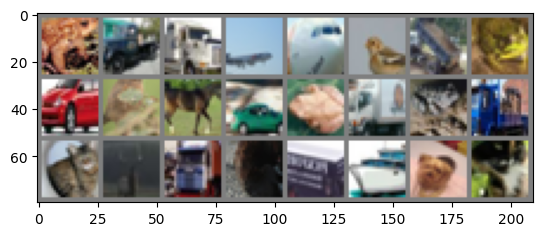

 frog truck truck plane plane  bird truck  frog
   car  bird horse   car  frog truck  frog truck
   cat  deer truck   cat truck  ship   dog   cat



In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()


CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
images, labels = next(iter(trainloaders[0]))
n_show = (BATCH_SIZE // 8) * 8
imshow(make_grid(images[:n_show]))
print(' '.join('%5s' % CLASSES[labels[j]] + ("\n" if (j + 1) % 8 == 0 else "") for j in range(n_show)))

Train the model and then test the model performance on the test set once the training is finished.

In [ ]:
trainloader = trainloaders[0]
valloader = valloaders[0]

for epoch in range(NUM_EPOCHS):
    loss, accuracy = train(net, trainloader, optimizer, epochs=1, verbose=False)
    print(f"Epoch {epoch + 1}: train loss {loss}, train accuracy {accuracy}")
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch + 1}: validation loss {loss}, validation accuracy {accuracy}")
    
loss, accuracy = test(net, testloader)
print(f"Final test set performance: loss {loss}, accuracy {accuracy}")

Epoch 1: train loss 1.7736273895369636, train accuracy 0.3371111111111111
Epoch 1: validation loss 1.5899440145492554, validation accuracy 0.4118
Epoch 2: train loss 1.5345026422540347, train accuracy 0.4379777777777778
Epoch 2: validation loss 1.5319123876094818, validation accuracy 0.4426
Epoch 3: train loss 1.4382382971048355, train accuracy 0.47886666666666666
Epoch 3: validation loss 1.4075347077846527, validation accuracy 0.489
Epoch 4: train loss 1.3701888189050886, train accuracy 0.5070666666666667
Epoch 4: validation loss 1.4073718944191933, validation accuracy 0.502
Epoch 5: train loss 1.3167022481560706, train accuracy 0.5286
Epoch 5: validation loss 1.3519480073451995, validation accuracy 0.524
Epoch 6: train loss 1.2750560761491458, train accuracy 0.5460444444444444
Epoch 6: validation loss 1.277368358671665, validation accuracy 0.5496
Epoch 7: train loss 1.2510136355625259, train accuracy 0.5558444444444445
Epoch 7: validation loss 1.2302231657505036, validation accuracy 